# Setting up the Carla system

In [1]:
# Importing relevant libraries
import math
import random
import time
import glob
import os
import sys
import numpy as np
#import cv2
import carla

### Establishing client and server connection and calling the blueprint

In [2]:
# Connects the client with the server
client = carla.Client('localhost', 2000)

# Load a new map if you want to
world = client.load_world('Town04') # Set the fog=0 for this map
#world = client.load_world('Town06')

RuntimeError: time-out of 5000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000

In [8]:
world = client.get_world()

weather = world.get_weather()
weather.cloudiness = 100
weather.fog_density = 0
world.set_weather(weather)

# Retrieve all traffic light actors in the world
traffic_lights = world.get_actors().filter("traffic.traffic_light*")

# Disable all traffic lights by setting them to green permanently
for traffic_light in traffic_lights:
    traffic_light.set_state(carla.TrafficLightState.Green)
    traffic_light.set_green_time(100000)  # Set a long green duration to effectively disable

In [24]:
world = client.get_world()
weather = world.get_weather()
weather = carla.WeatherParameters(
    cloudiness=50.0,              # Cloud cover percentage (0.0 to 100.0)
    precipitation=30.0,           # Rain intensity percentage (0.0 to 100.0)
    precipitation_deposits=20.0,  # Water accumulation on surfaces (0.0 to 100.0)
    wind_intensity=10.0,          # Wind intensity percentage (0.0 to 100.0)
    sun_altitude_angle=45.0,      # Sun height relative to the horizon (-90.0 to 90.0)
    sun_azimuth_angle=90.0,       # Sun position on the horizontal plane (0.0 to 360.0)
    fog_density=20.0,             # Fog density percentage (0.0 to 100.0)
    fog_distance=100.0,           # Fog start distance in meters
    fog_falloff=2.0,              # Rate at which fog density increases
    scattering_intensity=1.0,     # Light scattering intensity
    mie_scattering_scale=0.5,     # Scattering caused by atmospheric particles
    rayleigh_scattering_scale=0.03,  # Scattering that affects sky color
    wetness=40.0,                 # Wetness of surfaces (0.0 to 100.0)
    ice_thickness=0.0,            # Thickness of ice on surfaces (0.0 to 100.0)
    snow_amount=10.0,             # Intensity of snowfall (0.0 to 100.0)
    snow_puddles=5.0,             # Water puddles from melted snow (0.0 to 100.0)
    snow_depth=8.0                # Depth of accumulated snow (0.0 to 100.0)
)
world.set_weather(weather)

In [4]:
# Creates a world object to represent the simulation and act as an abstract layer containing the methods to spawn actors
# World object gets destroyed when loading a new map
world = client.get_world()

In [4]:
# Retrieving the blueprint library to access the blueprint
bp_lib = world.get_blueprint_library()

# Obtaining the spawn points
spawn_points = world.get_map().get_spawn_points()

# FYI - to get random location of pedestrians
# sidewalk = world.get_random_location()

In [5]:
print(bp_lib[0])

ActorBlueprint(id=vehicle.nissan.micra,tags=[vehicle, nissan, micra])


In [7]:
len(spawn_points)

155

### Tweaking the weather

In [10]:
# Add Fog
weather = world.get_weather()
#weather.sun_altitude_angle = 100
weather.fog_density = 50
world.set_weather(weather)

### Spawning a car

In [11]:
# Obtaining a vehicle from thhe blueprint and spawning it in one of the pre-defined spawn points
actor_list = []  # Creates a list of actors spawned on the map
spawn_point = spawn_points[0]
vehicle_bp = bp_lib.find('vehicle.lincoln.mkz_2020')
shifted_spawn_point = carla.Transform(spawn_point.transform(carla.Location(x = 0)), 
                           spawn_point.rotation)
vehicle = world.spawn_actor(vehicle_bp, shifted_spawn_point)
actor_list.append(vehicle)

# To control the car
# vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer=0.0))

NameError: name 'spawn_points' is not defined

In [11]:
# Printing the 1st spawn point which is also the car's spawn point
print(spawn_points[0])

Transform(Location(x=106.416290, y=-12.711931, z=0.599999), Rotation(pitch=0.000000, yaw=-89.609253, roll=0.000000))


In [12]:
# Retrieving the vehicle position and printing it
# Transform must not be confused with any type of transformation. It only deals with the position of the object
vehicle_pos = vehicle.get_transform()
print(vehicle_pos)

Transform(Location(x=106.416290, y=-12.711931, z=0.577559), Rotation(pitch=0.000000, yaw=-89.609253, roll=0.000000))


### Setting spectator to position relative to the car

In [6]:
# Retrieve the spectator object
spectator = world.get_spectator()

# Here the spectator is being positioned relative to the position of the car - Relative coordinate system
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-6,z=2)), 
                            vehicle.get_transform().rotation)

# Alternate method of defining transform position - Absolute coordinate
# transform = carla.Transform(vehicle_pos.location + carla.Location(y=6,z=2),
#                             carla.Rotation(yaw = vehicle_pos.rotation.yaw - 0))
spectator.set_transform(transform)

In [10]:
class ABC:
    img = None
abc = ABC()

### Spawning a camera and attaching it to the car

In [12]:
IM_WIDTH = 224
IM_HEIGHT = 224

# Defining a function where you're using Open CV to be able to see the camera's pov in real time
def process_img(image):
    i = np.array(image.raw_data)  # Convert image to array
    i2 = i.reshape((IM_HEIGHT, IM_WIDTH, 4))  # Reshape the flattened array into the image shape
    i3 = i2[:, :, :3]   # Removing the alpha
    abc.img = i3

In [13]:
# Retrieves the RGB camera object
camera_bp = bp_lib.find('sensor.camera.rgb')

# Setting image attributes
camera_bp.set_attribute("image_size_x", f"{IM_WIDTH}")
camera_bp.set_attribute("image_size_y", f"{IM_HEIGHT}")
camera_bp.set_attribute("fov", "110")

# Adjust camera sensor relative to the car
# This position will be given relative to the object attached to it
camera_init_transform = carla.Transform(carla.Location(x=0.7,z=1.5))

# Spawn the sensor and attach it to the vehicle
camera = world.spawn_actor(camera_bp, camera_init_transform, attach_to=vehicle)
actor_list.append(camera)

# Calls "listening" attribute of the camera to record the images and save them in a folder
# Method 1: Watch the POV live
camera.listen(lambda data: process_img(data))

# Method 2: - save to disk directly
# camera.listen(lambda image: image.save_to_disk('output/%06d.png' % image.frame))
# camera.listen(lambda image : print(image.frame))

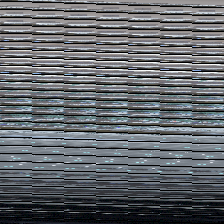

In [14]:
from PIL import Image
from matplotlib import cm
# im = Image.fromarray(np.uint8(cm.gist_earth(myarray)*255))

Image.fromarray(abc.img)

In [15]:
camera.stop()

In [24]:
vehicle.apply_control(carla.VehicleControl(throttle=0.6, steer=0.0,reverse =False))

### Cleaning up after your work - destroying all actors

In [ ]:
# Method 1
for actor in actor_list:
    actor.destroy()

In [ ]:
# Method 2
# Utility code to destroy actors
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

### Spawning a few number cars at random points and setting them into autopilot mode

In [ ]:
# Spawns other vehicles at random places
for i in range(30):
    vehicle_bp = random.choice(bp_lib.filter('vehicle'))
    npc = world.try_spawn_actor(vehicle_bp, random.choice(spawn_points))

In [ ]:
# Sets all vehicles to autopilot mode
for v in world.get_actors().filter('*vehicle*'):
    v.set_autopilot(True)

In [ ]:
camera.stop()

In [ ]:
# Utility code to destroy actors
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

### Setting up a semantic segmentation camera

In [ ]:
# usual - spaw a car and set Autopilot on
vehicle_bp = world.get_blueprint_library().filter('*model3*')
start_point = spawn_points[0]
vehicle = world.spawn_actor(vehicle_bp[0], start_point)
vehicle.set_autopilot(True)

#camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
CAMERA_POS_Z = 1.6 #this means 1.6m up from the ground
CAMERA_POS_X = 0.9 #this is 0.9m forward

#semantic camera
camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', '360')
camera_init_trans = carla.Transform(carla.Location(x=CAMERA_POS_X,z=CAMERA_POS_Z))
camera_sem = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))
    # The RGB camera is technically the RGBA camera, where is alpha which gives you information about that pixel
    i3 = data_dict['sem_image'][:, :, :3]   # Removing the alpha
    cv2.imshow("", i3)  # Display the image
    cv2.waitKey(1)
    return i3  # Normalising the data
    
image_w = 640
image_h = 360

camera_data = {'sem_image': np.zeros((image_h,image_w,4))}

# this actually opens a live stream from the cameras
camera_sem.listen(lambda image: sem_callback(image,camera_data))

In [ ]:
camera_sem.stop()

In [ ]:
# Save the images with acc and steer data using the save_to_disk attribute
# Save the acc and break data in a CSV/Excel file and then use this data to save it to its corresponding image
# You can display the acc and steer value on the image if you would like to
# Do it by using # camera.listen(lambda image: image.save_to_disk('output/%06d.png' % image.frame, f{ACC_DATA,}, f{BREAK_DATA}))

## Listing all attributes of carla.CityObjectLabel

In [6]:
import carla

# List all attributes of CityObjectLabel
labels = dir(carla.CityObjectLabel)

# Filter out special/magic attributes (those starting with "__")
labels = [label for label in labels if not label.startswith("__")]

# Display the labels
print(labels)

['Any', 'Bicycle', 'Bridge', 'Buildings', 'Bus', 'Car', 'Dynamic', 'Fences', 'Ground', 'GuardRail', 'Motorcycle', 'NONE', 'Other', 'Pedestrians', 'Poles', 'RailTrack', 'Rider', 'RoadLines', 'Roads', 'Sidewalks', 'Sky', 'Static', 'Terrain', 'TrafficLight', 'TrafficSigns', 'Train', 'Truck', 'Vegetation', 'Walls', 'Water', 'as_integer_ratio', 'bit_length', 'conjugate', 'denominator', 'from_bytes', 'imag', 'name', 'names', 'numerator', 'real', 'to_bytes', 'values']


## Toggle buildings and other details

In [2]:
import carla

# Connect to the CARLA server
client = carla.Client('localhost', 2000)
client.set_timeout(5.0)
world = client.get_world()

# List of environment objects you want to check for and toggle off
object_labels = ["Buildings",  "TrafficLight", "Car", "Vegetation", "Railtrack", "Motorcycle", "Other"]

# Loop through the labels and toggle objects off if the label exists
for label in object_labels:
    if hasattr(carla.CityObjectLabel, label):
        # Get all environment objects for this label
        env_objects = world.get_environment_objects(getattr(carla.CityObjectLabel, label))
        
        # Collect object IDs to toggle
        objects_to_toggle = {obj.id for obj in env_objects}
        
        # Toggle the objects off
        world.enable_environment_objects(objects_to_toggle, True)

        # Alternatively toggle on the objects
        #world.enable_environment_objects(objects_to_toggle, True)
        print(f"Toggled all objects for label: {label}")
    else:
        print(f"Label '{label}' not found in CityObjectLabel.")

Toggled all objects for label: Buildings
Toggled all objects for label: TrafficLight
Toggled all objects for label: Car
Toggled all objects for label: Vegetation
Label 'Railtrack' not found in CityObjectLabel.
Toggled all objects for label: Motorcycle
Toggled all objects for label: Other


In [29]:
import carla

# Connect to the CARLA server
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)

# Get the world
world = client.get_world()

# Get the details in the world
env_objs = world.get_environment_objects(carla.CityObjectLabel.Other)

# Access individual IDs and save in a set
#building_01 = env_objs[0]
#building_02 = env_objs[1]
#objects_to_toggle = {building_01.id, building_02.id}
objects_to_toggle = {obj.id for obj in env_objs}

# Toggle details off
world.enable_environment_objects(objects_to_toggle, False)

# Toggle buildings on
#world.enable_environment_objects(objects_to_toggle, True)

## Toggle traffic signal

In [2]:
# Get all traffic signals in the CARLA world
traffic_signals = world.get_environment_objects(carla.CityObjectLabel.TrafficLight)

# Create a set of traffic signal IDs to toggle
signals_to_toggle = {signal.id for signal in traffic_signals}

# Toggle traffic signals off (invisible)
world.enable_environment_objects(signals_to_toggle, False)

# To toggle them back on (visible), you can use:
# world.enable_environment_objects(signals_to_toggle, True)

AttributeError: type object 'CityObjectLabel' has no attribute 'TrafficLights'

## Destorying signals

In [ ]:
import carla

# Connect to the CARLA server
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)

# Get the world
world = client.get_world()

# Remove all traffic lights and stop signs
for actor in world.get_actors():
    if 'traffic_light' in actor.type_id or 'traffic_sign' in actor.type_id:
        actor.destroy()

print("All traffic lights and stop signs removed.")

## Setting signal to always display green

In [3]:
# Retrieve all traffic light actors in the world
traffic_lights = world.get_actors().filter("traffic.traffic_light*")

# Disable all traffic lights by setting them to green permanently
for traffic_light in traffic_lights:
    traffic_light.set_state(carla.TrafficLightState.Green)
    traffic_light.set_green_time(100000)  # Set a long green duration to effectively disable

NameError: name 'world' is not defined